<a href="https://colab.research.google.com/github/punkmic/Topic-Modeling-Reclame-Aqui/blob/master/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pre-Processing** 

### **Setup**

In [176]:
import pandas as pd # for data manipulation
import os # for interacting with the operating system
import nltk # for natural language processing
import string # for string manipulation 
import re # for for regular expressions
import matplotlib.pyplot as plt # for visualization
import spacy # for lemmatize portuguese text
import pickle
import seaborn as sns # for visualizations
from nltk.probability import FreqDist
try:
  from spellchecker import SpellChecker # for spell check
except:
  !pip install pyspellchecker
  from spellchecker import SpellChecker # for spell check

In [177]:
%%capture
# Install spacy pt_core_news_sm for portuguese text
!python -m spacy download pt_core_news_sm

In [178]:
# provides a set of unsupervised algorithms that can be used for tokenization
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [179]:
# Download dataset with stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [180]:
# Donwload datasets for lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [181]:
# Donwload dependency need to stem portuguese text
nltk.download('rslp')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

### **Load data from [Github](https://github.com/punkmic/Topic-Modeling-Reclame-Aqui.git)**

In [182]:
#!git clone https://github.com/punkmic/Topic-Modeling-Reclame-Aqui.git

In [183]:
# Change directory
%cd /content/Topic-Modeling-Reclame-Aqui 

# Update files from remote repository
!git pull 

# Check current directory
!pwd

/content/Topic-Modeling-Reclame-Aqui
Already up to date.
/content/Topic-Modeling-Reclame-Aqui


In [184]:
WORK_DIR = '/content/Topic-Modeling-Reclame-Aqui/datasets'

In [185]:
def read_data(path_csv, drop_duplicates = True, lower=True):
 
  # use the read_csv method to read csv file
  df = pd.read_csv(path_csv)
  
  if drop_duplicates:
    # read and return the CSV file using the read_csv method
    print(f"Shape before remove duplicates: {df.shape}")

    # use the drop_duplicated method to drop duplicates rows
    df = df.drop_duplicates(subset="text")

    print(f"Shape after remove duplicates: {df.shape}")

    if lower:
      # apply the str.lower() method to each element in the dataframe
      df = df.applymap(str.lower)
    
     # rename columns
    df.columns = ["title", "documents"] 

    # use the replace() method to replace the string with an empty string
    df = df.replace(re.compile('\[editado pelo reclame aqui\]|editado pelo reclame aqui|Editado pelo Reclame Aqui'), '')
    df = df.replace(re.compile('\[casas bahia\]|Casa Bahia|Casas Bahia|casa bahia'), '')
    df = df.replace(re.compile('\[magazine luiza\]|Magazine luiza|Magazine Luiza| Magazine luizar|Magazine Luizar'), '')
    df = df.replace(re.compile('\[mercado livre\]|Mercado Livre|Mercado livre'), '')
    df = df.replace(re.compile('\[americana\]|Ameriacanas|ameriacanas'), '')

  return df

### **Preprocessing**

#### **Tokenization**

Tokenization aims to breaking text down into its component parts

In [186]:
WORD_TOKENIZER = nltk.tokenize.word_tokenize
def tokenize(text):
  tokens = [token.strip().lower() for token in WORD_TOKENIZER(text, language="portuguese")]
 
  # set a pattern to detect patterns such as x x, xxx x, xxx xxx
  pattern = r"\b\w+\s+\w+\b"
 
  # filter tokens by pattern
  filtered_words = [word for word in tokens if re.search(pattern, word)]

  # return token if not in filter list
  return [token for token in tokens if token not in filtered_words]

#### **Stem** 

Stem the tokens. This step aims to remove morphological affixes and normalize to standardized stem forms

In [187]:
STEMMER = nltk.stem.RSLPStemmer()
def stem(tokens):
  return [STEMMER.stem(token) for token in tokens]

#### **Lemmatize**

Lemmatize the tokens. Retains more natural forms than stemming, but assumes all tokens nons unless tokens are passed as (word, pos) tuples. Note: nltk lemmatize does not suport portugues language

In [188]:
LEMMATIZER = nltk.WordNetLemmatizer()

def lemmatize(tokens):
  lemmas = []
  for token in tokens:
      if isinstance(token, str):
          # treats token like a noun
          lemmas.append(LEMMATIZER.lemmatize(token)) 
      else: 
          # assume a tuple of (word, pos)
          lemmas.append(LEMMATIZER.lemmatize(*token))
  return lemmas

**Lemmatize option for portuguese text**

In [189]:
# load portuguese model
nlp = spacy.load('pt_core_news_sm')

def lemmatize_pt(tokens):

  # Create a spaCy Doc object and apply the lemmatization
  doc = nlp(' '.join(tokens))

  # Return lemmatize
  return [token.lemma_ for token in doc]

#### **Remove stopwords**

Stop words are things like articles and conjunctions that usually do not offer a lot of value in an analysis.

In [190]:
custom_stop_words = ['amazon', 'americanas', 'casas bahia', 'magazine luiza', 'shein', 'kabum',
                       'samsung', 'mercado livre', 'banco brasil', 'apple', 'magazine', 'luiza', 'luizar',
                      'casas', 'bahia', 'casa', 'mercado', 'livre','magalu']

In [191]:
def remove_stopwords(tokens, stopwords=None, custom_stop_words = None):

  if custom_stop_words is None:
    custom_stop_words = ['amazon', 'americanas', 'casas bahia', 'magazine luiza', 'shein', 'kabum',
                       'samsung', 'mercado livre', 'banco brasil', 'apple', 'magazine', 'luiza', 'luizar',
                      'casas', 'bahia', 'casa', 'mercado', 'livre']

  # Use the default stop words if none is passed
  if stopwords is None:
    stopwords = nltk.corpus.stopwords.words('portuguese') + custom_stop_words    
  
  # Filter the list of tokens to exclude the stop word tokens
  return [token for token in tokens if token not in stopwords]

In [192]:
assert remove_stopwords(['compra', 'echar', 'em esse', 'amazon', 'pude'], custom_stop_words=custom_stop_words) == ['compra', 'echar', 'em esse', 'pude']

#### **Remove frequent words**

In [223]:
def remove_frequent_words(tokens, top_frequent = 20):
  # filter tokens by its frequency
  freq = nltk.FreqDist(tokens).most_common(top_frequent)
  freq = [item[0] for item in freq]
  tokens  =  [token for token in tokens if token not in freq]
  return tokens 

In [194]:
assert remove_frequent_words(['common', 'common', 'top', 'top', 'bottom'], 2) == ['bottom']

['common', 'top']


#### **Remove hyperlinks**

Removes http/s links from the tokens.

In [195]:
def remove_links(tokens):
  # Filter tokens that starts with "http://" or "https://"
  return [token for token in tokens 
          if not token.startswith("http://")
          and not token.startswith("https://")]

In [196]:
assert remove_links(['bom', 'http://online', 'https://offline']) == ['bom']

#### **Remove numbers**

In [197]:
def remove_numbers(tokens):
  # Use a regular expression to match words that contain numbers
  pattern = r"\b\w*\d\w*\b"
  tokens = [token for token in tokens if not re.sub(pattern, "", token) == ""]
  
  # Filter out number tokens using a list comprehension and the isnumeric method
  return [token for token in tokens if not token.isnumeric()]

In [198]:
assert remove_numbers(['ola', 'bicicleta', '1', '2002']) == ['ola', 'bicicleta']

#### **Remove date**

In [199]:
def remove_date(tokens):
  # Compile a regular expression to match dates in the format dd/mm or dd/mm/yyyy
  date_regex = re.compile(r'\d{2}/\d{2}(/\d{4})?')

  # Use the regex to find all the tokens that match the date pattern
  dates = [token for token in tokens if date_regex.fullmatch(token)]

  # Filter the list of tokens to exclude the date tokens
  filtered_tokens = [token for token in tokens if token not in dates]

  # Return the filtered tokens
  return filtered_tokens

In [200]:
assert remove_date(['texto', 'data', '20/10', 'seguro', '02/09/2014']) == ['texto', 'data', 'seguro']

#### **Remove punctuation**

In [201]:
def remove_punctuation(tokens,
                       strip_mentions=True,
                       strip_hashtags=True):

    tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]

    # Filter punctuation tokens
    tokens = [token.strip() for token in tokens if token not in string.punctuation]

    # Remove @ symbol from left side of tokens
    if strip_mentions:
        tokens = [t.lstrip(r"([!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~])\1+") for t in tokens]

    # Remove # symbol from left side of tokens
    if strip_hashtags:
        tokens = [t.lstrip(r"([!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~])\1+") for t in tokens]

    return tokens

In [202]:
assert remove_punctuation(['limpo', 'acento/  ///', 'simples???', 'onde', ',']) == ['limpo', 'acento', 'simples', 'onde']

#### **Remove short tokens**

In [203]:
def remove_short_tokens(tokens):
  # Filter the list of tokens to exclude tokens that are shorter than four letters
  filtered_tokens = [token for token in tokens if len(token) >= 4]

  # Return the filtered tokens
  return filtered_tokens

In [204]:
assert remove_short_tokens(['sair', 'um', 'correto', 'igual', 'oi', 'de', 'em']) == ['sair', 'correto', 'igual']

#### **Correction of spelling errors**

In [205]:
# Create a SpellChecker object
spell = SpellChecker(language='pt')

def check_spell_errors(text):
  result = []
  for token in text:
    # Correct the spelling errors in the text
    corrected_text = spell.correction(token)

    # If no correction is present user the original text
    if corrected_text == None:
      corrected_text =  token
  
    result.append(corrected_text)
  # Return the corrected text
  return result

#### **Remove extra white spaces**

In [206]:
def remove_whitespace(document):
    return  " ".join(document.split())

In [210]:
def preprocess_data(df, check_spell = False, rm_frequent_words=False, top_words=20):
  for colname in df.columns:
    # preprocess data
    df[colname]= df[colname].str.lower()
    df[colname]= df[colname].apply(remove_whitespace)

    df[colname] = df[colname].apply(tokenize)
    if check_spell:
      df[colname] = df[colname].apply(check_spell_errors)
    df[colname] = df[colname].apply(remove_links)
    df[colname] = df[colname].apply(remove_punctuation)
    df[colname] = df[colname].apply(remove_numbers)
    df[colname] = df[colname].apply(remove_date)
    df[colname] = df[colname].apply(remove_short_tokens)
    df[colname] = df[colname].apply(remove_stopwords)
    if remove_frequent_words:
      df[colname] = df[colname].apply(remove_frequent_words)
    df[colname] = df[colname].apply(lemmatize_pt) 
    df[colname] = df[colname].apply(lambda x: ' '.join(x))

    # Save the DataFrame to a CSV file
    df.to_csv(os.path.join(WORK_DIR, 'preprocessed_top_20_words_removed.csv'), index=False)

In [221]:
path_csv = os.path.join(WORK_DIR, "docs.csv")
df = read_data(path_csv)  
df.head(2)

Shape before remove duplicates: (12760, 2)
Shape after remove duplicates: (10510, 2)


,title,documents
0,pedido cancelado sem justificativa após uma se...,eu estava pesquisando bastante uma nova tv par...
1,pedido cancelado,eu sinceramente estou decepcionada com o amazo...


In [ ]:
preprocess_data(df=df, rm_frequent_words=True)

In [84]:
d = pd.read_csv(os.path.join(WORK_DIR , 'preprocessed_top_20_words_removed.csv'))
print(d.shape)
d.head(2)

(10510, 2)


,title,documents
0,pedir cancelado justificativa após semana compro,pesquisando bastante novo comprar resolver agu...
1,pedir cancelar,sinceramente decepcionar entrar contato procon...


#### **Most Frequent words**

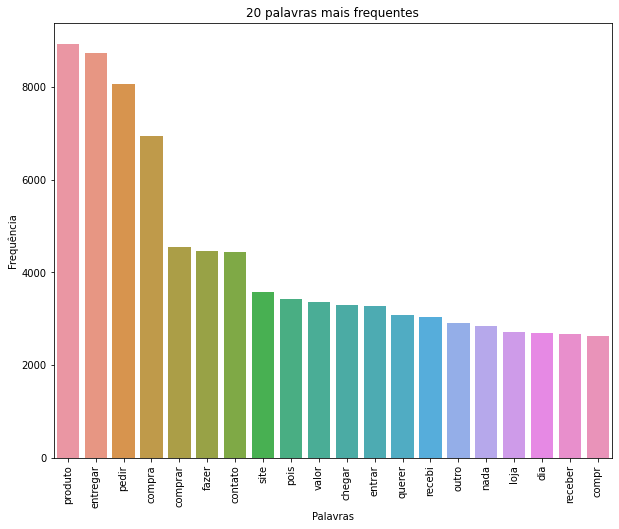

In [86]:
# split the text column into words
d['words'] = d['documents'].str.split()

# get the frequency of each word
word_freq = d['words'].explode().value_counts()

# get the 20 most frequent words
most_common_words = word_freq.head(20)

# figsize
plt.figure(figsize=[10,8])

# create a bar plot
sns.barplot(x = most_common_words.index, y = most_common_words.values)

# add labels and title
plt.xlabel("Palavras")
plt.ylabel("Frequência")
plt.title("20 palavras mais frequentes")

# rotate x-axis labels
plt.xticks(rotation=90)

# save figure
plt.savefig(os.path.join('/content/Topic-Modeling-Reclame-Aqui/results', 'top_20_frequent_words_removed.png'))

# Show the plot
plt.show()

#### **Github**

In [1]:
! ssh-keygen -t rsa -b 4096
# Add github.com to our known hosts
! ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
# Restrict the key permissions, or else SSH will complain.
! chmod go-rwx /root/.ssh/id_rsa

Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): 
Created directory '/root/.ssh'.
Enter passphrase (empty for no passphrase): 
Enter same passphrase again: 
Your identification has been saved in /root/.ssh/id_rsa.
Your public key has been saved in /root/.ssh/id_rsa.pub.
The key fingerprint is:
SHA256:OZtriREUXfX6x4FXhpkVU3wXtvs4bbDfy64fWTcRtBE root@63b3c6ac69cd
The key's randomart image is:
+---[RSA 4096]----+
|      .o .... .EB|
|      . .    ..=X|
|     .        =+=|
|      .  .   ...+|
|       .S   ...=o|
|      .  +   ..*B|
|       oo.    =o*|
|      . o.    .=o|
|       ..    .+=+|
+----[SHA256]-----+
# github.com:22 SSH-2.0-babeld-a17d9d27


In [2]:
! cat /root/.ssh/id_rsa.pub

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQDN54jogPMUo/TVjm9LseTw9EpXDjeTp0XA+QIU1e07HwGU82HqToNYkarDz3dOTE1Mnm5BifuuMe0NmHrMxWgJi0RBaDIX2z+KaW1nE8oD9R661HJ4lLgutArAJOWp9dij6SJiB7hX82DXFLWmopZBEYgaxdB6aca/LsIU8xQCc/xjmS78uiBqjv7KHFQkjPCrhmwIEOtMSl7ye/zlBhFMXoHLa1xlSN8ZMlVccA3Ogl13MMdnTshPhYD3/LW3lcUU829AYzwOjvm53v5Zwa8M6AJLAg8VAslUN/xSxIs8I0AXdf2LtQWd0waV3MQFptG24OCwi9GxLexortXYyAWi4UG6HFSrelmDlF+gRh58ZYnRa+7sZWyzq3RfDkxJN+Ny5v8tGluY+twkLdZmTTLP6emsjVyhiodbDZLxJ17f8G+uv7rrkHrZg7w57rr3qtSmZ5JTHxwTt43qhl061mozCFqLhpvKC3Njf2//dFIMRsVexPKZLeu6OBPBR55fhJgwr6/u0pIWkxHp5q6BfwyqqdJ2ZMgvGJq+0d+RxRHcJgQd3jRhIg9pioaDketbapp0lQeUvQztwv92WtiScicBuI2jXYnz3w5jWEKgD/aU2MKAtBbWEmAV696ZOtOL46kznDxZynvcZNOwVWTbiSVoXhSjdN6HWwnu/+PJ5Ou6ow== root@63b3c6ac69cd


In [3]:
!git config --global user.email "mattheus_ribeiro@outlook.com"
!git config --global user.name "punkmic"

In [4]:
!ssh -T git@github.com

Hi punkmic! You've successfully authenticated, but GitHub does not provide shell access.


In [5]:
!git clone git@github.com:punkmic/Topic-Modeling-Reclame-Aqui.git

Cloning into 'Topic-Modeling-Reclame-Aqui'...
remote: Enumerating objects: 16347, done.
remote: Counting objects: 100% (2166/2166), done.
remote: Compressing objects: 100% (1793/1793), done.
remote: Total 16347 (delta 345), reused 2149 (delta 338), pack-reused 14181
Receiving objects: 100% (16347/16347), 129.25 MiB | 18.40 MiB/s, done.
Resolving deltas: 100% (1493/1493), done.
Checking out files: 100% (14816/14816), done.


In [6]:
%cd /content/Topic-Modeling-Reclame-Aqui/

/content/Topic-Modeling-Reclame-Aqui


In [225]:
!git add ./datasets/preprocessed_top_20_words_removed.csv ./results/top_20_frequent_words.png ./results/top_20_frequent_words_removed.png

In [226]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	new file:   datasets/preprocessed_top_20_words_removed.csv
	new file:   results/top_20_frequent_words.png
	new file:   results/top_20_frequent_words_removed.png



In [227]:
!git commit -m "Adding frequent words plot"

[master 2b8e09f] Adding frequent words plot
 3 files changed, 10511 insertions(+)
 create mode 100644 datasets/preprocessed_top_20_words_removed.csv
 create mode 100644 results/top_20_frequent_words.png
 create mode 100644 results/top_20_frequent_words_removed.png


In [228]:
!git push origin master

Counting objects: 6, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 1.91 MiB | 3.22 MiB/s, done.
Total 6 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:punkmic/Topic-Modeling-Reclame-Aqui.git
   95552a0..2b8e09f  master -> master


In [ ]:
# run this command to push a new version of this notebook in case you have saved the notebook in github and it is outdate 
!git stash
!git pull
!git stash pop

In [229]:
!rm -rf /root/.ssh/